In [117]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

import jieba
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from collections import Counter
import torchtext
glove = torchtext.vocab.GloVe(name="6B", # Specified corpus used to train embedding
                              dim=50)    # Specified dimension of embedding

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Embedding Sections

## Embedding Class
-  takes in a tensor, desired output dimension, and number of words in the output space, and blow it up to such

In [11]:
class  Embeddings(nn.Module):
    def __init__(self, dim_model, vocab_size):
        '''
        dim_model, dimension of  word embedding
        vocab_size, number of  entries in the vocab
        '''
        super(Embeddings, self).__init__()

        self.lut = nn.Embedding(vocab_size, dim_model)
        self.dim_model = dim_model

    def forward(self, x):
        '''
        regularize  the input by the square root of dim model
        '''
        return self.lut(x) * math.sqrt(self.dim_model)

In [12]:
x = Variable(torch.LongTensor([[30, 90, 88, 27],
                               [403, 254, 337, 20]]))
emb = Embeddings(512, 1000)
embedded = emb(x)
print("Embedded Shape:", embedded.shape)

Embedded Shape: torch.Size([2, 4, 512])


## Positional Embedding
- Odd number Indices: PE = sin(pos/10000^(2i/dim_model))
- EVen number Indices: PE = cos(pos/10000^(2i/dmodel))

In [18]:
class PositionalEncoding(nn.Module):
    def  __init__(self, dim_model, p_dropout, max_len=5000):
        '''
        dim_model, the dimension of embedding
        dropout,  the probability of  dropping out
        max_len, the longest possible sequence length
        '''
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p_dropout)

        # Initiallize Positional embedding
        pe = torch.zeros(max_len, dim_model)

        # Initialize tensor for each position
        # each entry will correspond to index at that position
        position = torch.arange(0, max_len).unsqueeze(1)

        # For each seqence we have index tensor "position" that
        # ranges from [0, max_len] and is of shape max_len by 1
        # We want to generate a index array for the embeddings
        # in the model which means we require an array of size
        # max_len by dim_model. We obtain this array by multipling
        # the position array by div_term matrix of size 1 by dim_model

        # In addition to changing the dimension, the div_term matrix should also
        # minimize the entries of the matrix which would help the gradient descent to
        # converge in later training

        # We implement the above by a regularization using exponention and logarithm
        # Notice how we initialize an div_term of half of dim_model which does not make
        # sense for matrix multiplication, this is done this such that we are able to compute
        # the position term of odd indices and even indivces separately

        # If dim_model = 512, div_term is of size 1 by 256, then position * div_term
        # would be 512 by 1 * 1 by 256 which would yield a tensor of 512 by 256 which is
        # sufficient for representing either the odd or the even indices. We can view the following
        # operation as initializing the positional embedding twice, first on the sin with odd indices and
        # then on the coisne with even indices.
        # Then the following would yield a poistional embedding of size torch.Size([1, 60, 512])
        # Lastly, we register the posistion embeddiong as buffer. A buffer can be thought of as an important
        # component of the model that does not require gradient but should be recorded and saved

        div_term = torch.exp(torch.arange(0, dim_model,  2) * -(math.log(10000.0) / dim_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        '''
        Take in a x of batch_size by max_sequence_len by embedding_size
        even though the max_sequence length is 5000, it is such a big number
        and sequence of that length is imporbable. In this case, we simply replace the
        2nd dimension of input x with x.size(1) and since positional embedding does not requires
        gradeient, we set it to false.
        '''
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [20]:
x =  Variable(torch.LongTensor([[100, 2, 421, 508],
                                [491, 998, 1, 221]]))
emb = Embeddings(512, 1000)
embedded = emb(x)

x = embedded
pe = PositionalEncoding(512, 0.1, 60)
output = pe(x)

print("Positional Result Size:", output.shape)

Positional Result Size: torch.Size([2, 4, 512])


# Encoder Section

## Masking
- used in calculation of attention. When generating attention, it is possible to generate future values for the decoder. This is not useful for the training and we want to mask them

In [21]:
def subsequent_mask(size):
    # We form an upper traingular matrix for masking matrix
    # with dimension from the input size. We change the type to uint8
    # for efficient use of memory
    subsequent_mask = np.triu(np.ones((1, size, size)), k = 1).astype("uint8")
    # we convert the numpy to lower triangular and change to torch.tensor
    return torch.from_numpy(1 - subsequent_mask)

Subsequent mask: tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)


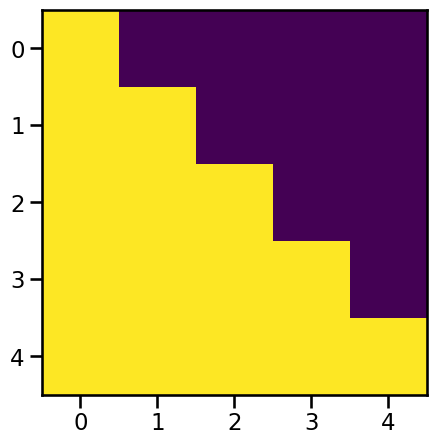

In [23]:
output = subsequent_mask(5)
print("Subsequent mask:", output)
plt.figure(figsize=(5,5))
plt.imshow(output[0])
plt.show()

## Attention QKV Calculation
- attention gives salience to porition of the input
- The weight derived from Q and K will be done by dot-product attention and additive attention

In [32]:
def attention(query, key, value, mask=None, dropout=None):

    dim_k = query.size(-1) # The last dim of query, usually the dimension of word embedding
    # Using the formula for attention, we compute the scores
    # here the the last two dimenion of the key  is switched such that the dimension matches up
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dim_k)

    # For masking operation, if required, we use the mask_fill method for tensor and
    # replaces all the 0 with -1e9
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    # Apply softmax to the attention score, where dim = -1 means a scalar
    p_attention = F.softmax(scores, dim = -1)

    if dropout:
        p_attention = dropout(p_attention)

    return torch.matmul(p_attention, value), p_attention

In [33]:
x = Variable(torch.LongTensor([[30, 90, 88, 27],
                               [403, 254, 337, 20]]))
emb = Embeddings(512, 1000)
embedded = emb(x)

x = embedded
pe = PositionalEncoding(512, 0.1, 60)
pe_output = pe(x)
print("Positional Embedding shape:", pe_output.shape)

query = key =value = pe_output

mask = Variable(torch.zeros(2, 4, 4))
attn, p_attn = attention(query, key, value, mask=mask)

print("Attention Shape:", attn.shape)
print("P attention Shape:", p_attn.shape)

Positional Embedding shape: torch.Size([2, 4, 512])
Attention Shape: torch.Size([2, 4, 512])
P attention Shape: torch.Size([2, 4, 4])


## Multihead Self-Attention
- Compute representation by dividing embedding space into different subspaces to process


In [39]:
def clones(module, n):
    '''
    In multihead attention, multiple linear layer that are identical are used
    they will be initialized by the clones function
    module is the layer we want to copy, and N is the number of copy
    '''
    # We use a for loop to copy from module N times
    return nn.ModuleList([copy.deepcopy(module) for _ in range(n)])

class MultiHeadedAttention(nn.Module):
    def __init__(self, head, embedding_dim, dropout=0.1):
        '''
        head as in the number of head
        embedding_dim is the dimension of embedding
        dropout, is the rate for dropout
        '''
        super(MultiHeadedAttention, self).__init__()

        # Use the assert function to check if embedding_dim can be
        # divided by the number of heads
        assert embedding_dim % head == 0
        self.dim_k = embedding_dim // head
        self.head = head
        # Here we requires four clones for since Q, K, V each requires 1
        # and the concatenation also requires one
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)
        self.attention = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(0)

        # Number of sequence
        batch_size = query.size(0)

        # We apply the zip function on linear layers and QKV such that we can
        # iterate through each linear layer as well as QKV
        # When at each iteration, we pass, the matrix into the linear model
        # and we use the view method to reformat its output adding an dimension
        # for number of heads which allows each head to receive a part of the input sequence
        # -1  means a dimension that fits with the rest

        query, key, value = \
            [model(x).view(batch_size, -1, self.head, self.dim_k).transpose(1,2)
              for model, x in zip(self.linears, (query, key, value))]

        # After obtaining the input from each head, we pass it to the attention
        x, self.attention = attention(query, key, value, mask=mask, dropout=self.dropout)

        # We reverse the reformat we done in previous steps using the .contiguous() method
        # which then allows us to reformat by .view()
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.head*self.dim_k)

        # Apply the final linear layer and output the result of multiheaded attention
        return self.linears[-1](x)

In [40]:
x = Variable(torch.LongTensor([[30, 90, 88, 27],
                               [403, 254, 337, 20]]))
emb = Embeddings(512, 1000)
embedded = emb(x)

x = embedded
pe = PositionalEncoding(512, 0.1, 60)
pe_output = pe(x)
print("Positional Embedding shape:", pe_output.shape)

query = key =value = pe_output

attn, p_attn = attention(query, key, value)
mask = Variable(torch.zeros(8, 4, 4))

mha = MultiHeadedAttention(8, 512, 0.2)
mha_output = mha(query, key, value, mask)
print("Multi Headed Attention Output:", mha_output.shape)

Positional Embedding shape: torch.Size([2, 4, 512])
Multi Headed Attention Output: torch.Size([2, 4, 512])


## Feed Forward Layer

In [45]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, dim_model, dim_ff, dropout=0.1):
        '''
        dim_model, input dim
        dim_ff, output dim, usually we want the same dimension
        '''
        super(PositionwiseFeedForward, self).__init__()

        self.w1 = nn.Linear(dim_model, dim_ff)
        self.w2 = nn.Linear(dim_ff, dim_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(F.relu(self.w1(x))))

In [46]:
x = Variable(torch.LongTensor([[30, 90, 88, 27],
                               [403, 254, 337, 20]]))
emb = Embeddings(512, 1000)
embedded = emb(x)

x = embedded
pe = PositionalEncoding(512, 0.1, 60)
pe_output = pe(x)
print("Positional Embedding shape:", pe_output.shape)

query = key =value = pe_output

attn, p_attn = attention(query, key, value)
mask = Variable(torch.zeros(8, 4, 4))

mha = MultiHeadedAttention(8, 512, 0.2)
mha_output = mha(query, key, value, mask)

ff = PositionwiseFeedForward(512, 64, 0.2)
ff_output = ff(x)
print("Feed Forward Output Size:", ff_output.size())

Positional Embedding shape: torch.Size([2, 4, 512])
Feed Forward Output Size: torch.Size([2, 4, 512])


## Normalization Layer

In [48]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        '''
        features, dimension of embedding
        eps, a very small number used in normalization to prevent denominator from being 0
        '''
        super(LayerNorm, self).__init__()

        # Record the parameter for moving average and for later calculatrion
        # we record thes parameter into a2 and b2 for regularization
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))

        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a2*(x-mean)/(std+self.eps) + self.b2

In [49]:
x = Variable(torch.LongTensor([[30, 90, 88, 27],
                               [403, 254, 337, 20]]))
emb = Embeddings(512, 1000)
embedded = emb(x)

x = embedded
pe = PositionalEncoding(512, 0.1, 60)
pe_output = pe(x)
print("Positional Embedding shape:", pe_output.shape)

query = key =value = pe_output

attn, p_attn = attention(query, key, value)
mask = Variable(torch.zeros(8, 4, 4))

mha = MultiHeadedAttention(8, 512, 0.2)
mha_output = mha(query, key, value, mask)

ff = PositionwiseFeedForward(512, 64, 0.2)
ff_output = ff(x)

x = ff_output

ln = LayerNorm(512, 1e-6)
ln_output = ln(x)
print("Norm Layer Output Shape:", ln_output.shape)

Positional Embedding shape: torch.Size([2, 4, 512])
Norm Layer Output Shape: torch.Size([2, 4, 512])


## Residual Connection
- access to prior gradients

In [50]:
class ResidualConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        '''
        size, dim of embedding
        dropout, rate of dropout
        '''
        super(ResidualConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x , reslayer):
        return x + self.dropout(reslayer(self.norm(x)))

In [53]:
x = Variable(torch.LongTensor([[30, 90, 88, 27],
                               [403, 254, 337, 20]]))
emb = Embeddings(512, 1000)
embedded = emb(x)

x = embedded
pe = PositionalEncoding(512, 0.1, 60)
pe_output = pe(x)
print("Positional Embedding shape:", pe_output.shape)

query = key =value = pe_output

attn, p_attn = attention(query, key, value)
mask = Variable(torch.zeros(8, 4, 4))

mha = MultiHeadedAttention(8, 512, 0.2)
mha_output = mha(query, key, value, mask)

ff = PositionwiseFeedForward(512, 64, 0.2)
ff_output = ff(x)

x = ff_output

ln = LayerNorm(512, 1e-6)
ln_output = ln(x)

self_attn = MultiHeadedAttention(8, 512)
sublayer = lambda x: self_attn(x, x, x, mask)
rs = ResidualConnection(512, 0.2)
rs_output = rs(x, sublayer)
print("Residual Layer Output Shape:", rs_output.shape)

Positional Embedding shape: torch.Size([2, 4, 512])
Residual Layer Output Shape: torch.Size([2, 4, 512])


## Encoder Layer
- putting it all together

In [61]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        '''
        size, dimension of embedding
        self_attention, object for multiheaded self attention
        feed_forward, layer for feed forward
        dropout, rate of dropout
        '''
        super(EncoderLayer, self).__init__()


        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.reslayer = clones(ResidualConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.reslayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.reslayer[1](x, self. feed_forward)

class Encoder(nn.Module):
    def __init__(self, layer, n):
      '''
      layer, what kind of encoder layer
      N, number of such layer
      '''
      super(Encoder, self).__init__()

      self.layers = clones(layer, n)
      self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)



In [62]:
size = 512
embedding_dim = 512
head_num = 8
dim_model = 512
dim_ff = 128
dropout = 0.2
max_len = 60
vocab_size = 1000
n = 8

x = Variable(torch.tensor([[30, 90, 88, 27],
                           [403, 254, 337, 20]]))
emb = Embeddings(embedding_dim, vocab_size)
pe = PositionalEncoding(embedding_dim, dropout, max_len)
self_attn = MultiHeadedAttention(head_num, dim_model)
ff = PositionwiseFeedForward(dim_model, dim_ff, dropout)

# Here we need to deepcopy the layers such that the
# the parameters won't be shared
c = copy.deepcopy
encoder_layer = EncoderLayer(size, c(self_attn), c(ff), dropout)
encoder = Encoder(encoder_layer, n)
mask = Variable(torch.zeros(8, 4, 4))

x = pe(emb(x))
y = encoder(x, mask)

print("Encoder Output Shape:", y.shape)

Encoder Output Shape: torch.Size([2, 4, 512])


# Decoder Section
- comprised of n decoder
- each encoder have three sublayer each withits own residual connection
-  1st Sublayer: masked multi-head attention, normalization
-  2nd Sublyaer: multi-head attention, normalization
-  3rd Sublayer: feedforwar, normalization

## Decoder

In [71]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        '''
        size, emmbedding dimension/encoder output dimension
        self_attn, multihead self attention Q = K = V
        src_attn, multi head attention where K = V, Q != K or V
        feed_forward, fully connected layer
        dropout, rate of dropout
        '''
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn  = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(ResidualConnection(size, dropout), 3)

    def forward(self, x, memory, source_mask, target_mask):
        '''
        x, input
        memory, attention matrix from encoder
        source mask
        target mask
        '''
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, target_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, source_mask))
        return self.sublayer[2](x, self.feed_forward)

class Decoder(nn.Module):
    def __init__(self, layer, n):
        '''
        layer, decoder layer
        n, number of layer
        '''
        super(Decoder, self).__init__()
        self.layers = clones(layer, n)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, source_mask, target_mask):
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        return self.norm(x)

In [74]:
size = 512
embedding_dim = 512
head_num = 8
dim_model = 512
dim_ff = 128
dropout = 0.2
max_len = 60
vocab_size = 1000
n = 8

x = Variable(torch.tensor([[30, 90, 88, 27],
                           [403, 254, 337, 20]]))
emb = Embeddings(embedding_dim, vocab_size)
pe = PositionalEncoding(embedding_dim, dropout, max_len)
attn = MultiHeadedAttention(head_num, dim_model)
self_attn = src_attn = MultiHeadedAttention(head_num, dim_model, dropout)
ff = PositionwiseFeedForward(dim_model, dim_ff, dropout)

# Here we need to deepcopy the layers such that the
# the parameters won't be shared
c = copy.deepcopy
encoder_layer = EncoderLayer(size, c(self_attn), c(ff), dropout)
encoder = Encoder(encoder_layer, n)
mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask

decoder_layer = DecoderLayer(dim_model, c(attn), c(attn), c(ff), dropout)
decoder = Decoder(decoder_layer, n)

x = pe(emb(x))
memory = encoder(x, mask)
y = decoder(x, memory, source_mask, target_mask)


print("Decoder Output Shape:", y.shape)

Decoder Output Shape: torch.Size([2, 4, 512])


## Generator

In [83]:
class Generator(nn.Module):
    def __init__(self, dim_model, vocab_size):
        '''
        dim_model, embedding dimenison
        vocab_size, size of vocabulary
        '''
        super(Generator, self).__init__()
        self.project = nn.Linear(dim_model, vocab_size)
    def forward(self, x):
        # Function can be log or normal does not matter as much
        return F.log_softmax(self.project(x), dim=-1)

In [84]:
size = 512
embedding_dim = 512
head_num = 8
dim_model = 512
dim_ff = 128
dropout = 0.2
max_len = 60
vocab_size = 1000
n = 8

x = Variable(torch.tensor([[30, 90, 88, 27],
                           [403, 254, 337, 20]]))
emb = Embeddings(embedding_dim, vocab_size)
pe = PositionalEncoding(embedding_dim, dropout, max_len)
attn = MultiHeadedAttention(head_num, dim_model)
self_attn = src_attn = MultiHeadedAttention(head_num, dim_model, dropout)
ff = PositionwiseFeedForward(dim_model, dim_ff, dropout)

# Here we need to deepcopy the layers such that the
# the parameters won't be shared
c = copy.deepcopy
encoder_layer = EncoderLayer(size, c(self_attn), c(ff), dropout)
encoder = Encoder(encoder_layer, n)
mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask

decoder_layer = DecoderLayer(dim_model, c(attn), c(attn), c(ff), dropout)
decoder = Decoder(decoder_layer, n)

gen = Generator(dim_model, vocab_size)

x = pe(emb(x))
memory = encoder(x, mask)
y = decoder(x, memory, source_mask, target_mask)

print("Output Probabilities:", gen(y))

Output Probabilities: tensor([[[-6.5075, -6.5529, -7.1920,  ..., -7.2614, -6.3057, -6.9275],
         [-7.2721, -7.2344, -7.7684,  ..., -6.1604, -6.4811, -7.8577],
         [-7.0733, -7.6152, -6.0051,  ..., -7.3485, -7.1835, -7.3827],
         [-8.1208, -6.6109, -7.4040,  ..., -6.2986, -7.5493, -7.1977]],

        [[-7.0054, -7.6876, -6.9287,  ..., -6.1694, -6.9670, -7.8618],
         [-5.9565, -6.3467, -7.0014,  ..., -7.3230, -7.7779, -7.0307],
         [-7.0521, -6.5760, -7.1587,  ..., -7.2381, -7.0088, -7.3629],
         [-6.6652, -6.4555, -5.7295,  ..., -5.9936, -8.4863, -6.7258]]],
       grad_fn=<LogSoftmaxBackward0>)


# Transformer Implemenation

In [89]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, source_embed, target_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = source_embed
        self.tgt_embed = target_embed
        self.generator = generator

    def forward(self, source, target, source_mask, target_mask):
        return self.decode(self.encode(source, source_mask), source_mask, target, target_mask)

    def encode(self, source, source_mask):
        return self.encoder(self.src_embed(source), source_mask)

    def decode(self, memory, source_mask, target, target_mask):
        return self.decoder(self.tgt_embed(target), memory, source_mask, target_mask)

In [90]:
size = 512
embedding_dim = 512
head_num = 8
dim_model = 512
dim_ff = 128
dropout = 0.2
max_len = 60
vocab_size = 1000
n = 8

x = Variable(torch.tensor([[30, 90, 88, 27],
                           [403, 254, 337, 20]]))
emb = Embeddings(embedding_dim, vocab_size)
pe = PositionalEncoding(embedding_dim, dropout, max_len)
attn = MultiHeadedAttention(head_num, dim_model)
self_attn = src_attn = MultiHeadedAttention(head_num, dim_model, dropout)
ff = PositionwiseFeedForward(dim_model, dim_ff, dropout)

# Here we need to deepcopy the layers such that the
# the parameters won't be shared
c = copy.deepcopy
encoder_layer = EncoderLayer(size, c(self_attn), c(ff), dropout)
encoder = Encoder(encoder_layer, n)
decoder_layer = DecoderLayer(dim_model, c(attn), c(attn), c(ff), dropout)
decoder = Decoder(decoder_layer, n)

mask = Variable(torch.zeros(8, 4, 4))
source_mask = target_mask = mask

source_embed = nn.Embedding(vocab_size, dim_model)
target_embed = nn.Embedding(vocab_size, dim_model)

# for testing's sake we let the source and target/label  and src_mask and tgt_mask
# be the same will not happen in real world
source = target = x
source_mask = target_mask = mask

generator = Generator(dim_model,  vocab_size)

autoencoder = Transformer(encoder, decoder, source_embed, target_embed, generator)
output = autoencoder(source, target, source_mask, target_mask)

print("Decoder Output Shape:", output.shape)

Decoder Output Shape: torch.Size([2, 4, 512])


## Transformer Model for Machine Translation

## Data Preprocessing
- cut_zh(), separate chinese sequence into words and adds space between them

In [297]:
class PrepareData:
    def __init__(self, en_path, cn_path, quantity):
        # Read in the file, split Chinese data by Word
        self.data_zh = self.read_data('chinese.zh')[:quantity]
        self.data_en = self.read_data('english.en')[:quantity]
        self.data_zh = self.cut_zh(self.data_zh)

        # Read into Seqeuence
        self.seq_en, self.seq_zh = self.load_data(self.data_en, self.data_zh)

        # Build Dictionary
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.seq_en)
        self.zh_word_dict, self.zh_total_words, self.zh_index_dict = self.build_dict(self.seq_zh)

        # Convert Sequences into ids
        self.seq_en_ids, self.seq_zh_ids = self.word_2_id(self.seq_en, self.seq_zh, self.en_word_dict, self.zh_word_dict)

        # Pad sequence
        self.pad_en, self.pad_zh = self.pad_sequence(self.seq_en_ids, self.seq_zh_ids, 60)

        # Batch Sequences
        self.batch_en, self.batch_zh = self.split_batch(self.pad_en, self.pad_zh, 32)


    def read_data(self, path):
        with open(path, "r", encoding="utf-8") as f:
            data = pd.Series(f.readlines())
            data = data.str.replace('\n', ' ')
        return data

    def cut_zh(self, data):
        data_cut =  data.apply(lambda x: " ".join(jieba.cut(x)))
        return data_cut

    def load_data(self, eng, zh):
        assert len(zh) == len(eng)
        length = len(zh)
        en = []
        cn = []

        for i in range(length):
            en.append(["BOS"] + word_tokenize(eng[i])+ ["EOS"])
            cn.append(["BOS"] + word_tokenize(zh[i]) + ["EOS"])
        return en, cn

    def build_dict(self, sentences, max_words = 50000):
        word_count = Counter()

        for sentence in sentences:
            for word in sentence:
                word_count[word] += 1

        # returns from the 1st to the max_words th most common
        # words and their number of  appearance
        ls = word_count.most_common(max_words)
        # total words is counted with BOS and EOS
        total_words = len(ls) + 2

        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict["UNK"] = len(word_dict.keys())+1
        word_dict["PAD"] = len(word_dict.keys())+1

        index_dict = {value: key for key, value in word_dict.items()}

        return word_dict, total_words, index_dict

    def word_2_id(self, en, cn, en_dict, cn_dict, sort=True):
        '''
        en, eng sequence
        cn, chinese sequence
        en_dict, eng dict
        cn_dict, cn dict
        sort, if sort sequence by length
        replace each word with their index in dictionary
        '''
        seq_num = len(en)
        seq_en_ids = [[en_dict[token] for token in seq] for seq in en]
        seq_cn_ids = [[cn_dict[token] for token in seq] for seq in cn]

        def len_sort(seq):
            '''
            Given sequences, sort the sequence by length
            '''
            return sorted(range(len(seq)), key = lambda x: len(seq[x]))

        if sort:
            sorted_index = len_sort(seq_en_ids)
            seq_en_ids = [seq_en_ids[i] for i in sorted_index]
            seq_cn_ids = [seq_cn_ids[i] for i in sorted_index]

        return seq_en_ids, seq_cn_ids

    def pad_sequence(self, en, cn, max_len):
        token = self.en_word_dict["PAD"]
        max_len = min(max([len(seq) for seq in en]), max_len)
        out_en = [seq + [token] * (max_len - len(seq)) if max_len >= len(seq) else seq[:max_len] for seq in en]
        out_cn = [seq + [token] * (max_len - len(seq)) if max_len >= len(seq) else seq[:max_len] for seq in cn]
        return out_en, out_cn

    def split_batch(self, en, cn, batch_size, shuffle=True):
        out_en = []
        out_cn = []

        indices = np.arange(0, len(en))
        batched = False
        while batched == False:
          try:
              indices = indices.reshape((len(en)//batch_size, batch_size))
              batched = True
          except ValueError as e:
              indices = indices[:-1]

        if shuffle: np.random.shuffle(indices)
        indices = indices.tolist()

        out_en = [[en[index] for index in batch] for batch in indices]
        out_cn = [[cn[index] for index in batch] for batch in indices]

        return np.array(out_en), np.array(out_cn)

    def get_seq(self): return self.seq_en, self.seq_zh
    def get_word_dict(self): return self.en_word_dict, self.zh_word_dict
    def get_id_dict(self): return self.en_index_dict, self.zh_index_dict
    def get_seq_ids(self): return self.seq_en_ids, self.seq_zh_ids
    def get_batch(self): return self.batch_en, self.batch_zh
    def get_padded(self): return self.pad_en, self.pad_zh



In [300]:
data = PrepareData("english.en", "chinese.zn", 200)
de, dz = data.get_word_dict()
ie, iz = data.get_id_dict()
pe, pz = data.get_padded()
be, bc = data.get_batch()